# Week 6 - Machine Learning and Casual Inference

In this notebook we will walk through methods that combine machine learning and causal inference in contexts where the main goal is to isolate a causal effect.

The main purpose of this notebook is to learn how to practically implement the methods you saw in class and to think about the scenarios in which these methods are useful.


## Estimating the Gender Wage Gap and Child Penalty

In the first 3 exercises we will try to estimate the **gender wage gap** and the effect of having a child on earnings, which have been a hot topic in economic research and among policyamkers for a while now. 

We will do this using data from the 2018 Current Population Survey (CPS) in the US. In particular, we will use the version of the CPS provided by the [NBER](https://www.nber.org).

The *raw* regressions of reference is the following: 

$$y_i = \beta_0 + \beta_1 female_i + \varepsilon_i $$

$$y_i = \delta_0 + \delta_1 child_i + \varepsilon_i $$

where $y_i$ is one of the labor outcomes that we will define below and $female_i$ is a dummy for being a woman, and $child_i$ is a dummy equal to 1 if individual $i$ has a child.

**Suppose that $y_i$ is hourly wage, what can be a threat that threat a causal interpretation of $\beta_1$?**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from matplotlib import style
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col


style.use("fivethirtyeight")

In [2]:
df = pd.read_stata("https://www.nber.org/morg/annual/morg18.dta")
# we take subset of data just to reduce computation time
df = df.sample(30000, replace=False, random_state=0)
df.head(5)

,hhid,intmonth,hurespli,hrhtype,minsamp,hrlonglk,hrsample,hrhhid2,serial,hhnum,...,ym_file,ym,ch02,ch35,ch613,ch1417,ch05,ihigrdc,docc00,dind02
103153,150909100105603,May,1.0,Civilian male primary individual,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0801,08011,1,1,...,700,697,0,0,0,0,0,NaN,Business and financial operations occupations,Professional and Technical services
76648,505760912076673,March,1.0,Husband/wife primary fam (neither in Armed For...,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0811,08111,1,1,...,698,695,0,0,0,0,0,12.0,NaN,NaN
51433,481462012350753,February,1.0,Husband/wife primary fam (neither in Armed For...,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0701,07011,1,1,...,697,694,0,0,0,0,0,NaN,Management occupations,Agriculture
75550,106518879410166,March,2.0,Husband/wife primary fam (neither in Armed For...,MIS 8,MIS 2-4 Or MIS 6-8 (link To,0611,06111,1,1,...,698,683,0,0,0,0,0,11.0,NaN,NaN
284643,466023401171104,December,1.0,Husband/wife primary fam (neither in Armed For...,MIS 4,MIS 2-4 Or MIS 6-8 (link To,0901,09011,1,1,...,707,704,0,1,1,0,1,13.0,Management occupations,Membership associations and organizations


In [3]:
# explore the labels of the variables
pd.read_stata('https://www.nber.org/morg/annual/morg18.dta', iterator=True).variable_labels()

{'hhid': 'Household ID',
 'intmonth': 'Interview Month',
 'hurespli': 'Line Number of Respondent',
 'hrhtype': 'Household Type',
 'minsamp': 'Month in sample (4 & 8 are departing)',
 'hrlonglk': 'Longitudinal Link Indicator',
 'hrsample': 'Sample indentifier',
 'hrhhid2': 'Household ID (partII)',
 'serial': 'Serial suffix',
 'hhnum': 'Household number',
 'stfips': 'State FIPS code',
 'cbsafips': 'Metropolitan CBSA FIPS code',
 'county': 'FIPS County Code',
 'centcity': 'Principal/Central city status',
 'smsastat': 'Metropolitan status code',
 'icntcity': 'Individual principal/central city code',
 'smsa04': 'Metropolitan Area (CBSA) size code',
 'relref95': 'Relationship to reference person',
 'age': 'Age',
 'spouse': "Spouse's line number",
 'sex': 'Sex',
 'grade92': 'Highest grade completed',
 'race': 'Race',
 'ethnic': 'Ethnicity',
 'lineno': "Person's Line Number",
 'famnum': 'Family number',
 'pfamrel': 'Primary family relationship',
 'marital': 'Marital status',
 'prpertyp': 'Type

In [4]:
# d variable:
df["female"] = (df['sex']==2).astype('int')
df['child'] = (df['ownchild']>0).astype('int')

# y variable:
df["log_earn"] = np.log(df['earnwke'])
df["log_earn"][np.isinf(df['log_earn'])] = np.nan

# hours (usual):
df["log_uhours"] = np.log(df['uhourse'])
df["log_uhours"][np.isinf(df['log_uhours'])] = np.nan

# hours (last week):
df["log_hourslw"] = np.log(df.hourslw)
df["log_hourslw"][np.isinf(df.log_hourslw)] = np.nan

# wage = earnigns / hours
df["log_wageu"] = df['log_earn'] - df['log_uhours']

In [5]:
print(df.female.value_counts())
print(df.child.value_counts())

female
1    15624
0    14376
Name: count, dtype: int64
child
0    22622
1     7378
Name: count, dtype: int64


**How would you try to isolate the effect of gender or of having a child on wages? Which of the techniques that we saw in class would you use here?**

## Propensity Score Matching

In this part we will focus on the estimation of the gender wage gap. We will focus on hourly wage ($log\_wageu$) as main outcome of interest.

In [6]:
olsf = smf.ols("log_wageu~female", df).fit(cov_type='hc1')
ols2f = smf.ols('log_wageu ~ female + log_hourslw + age + I(age**2) + C(race) + C(cbsafips) + C(smsastat) + C(grade92) + C(unionmme) + C(unioncov) + C(ind02) + C(occ2012)', df).fit(cov_type='hc1')

print(summary_col([olsf, ols2f], float_format='%0.3f',  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}, regressor_order=['female']))


                                                                                                                         log_wageu I log_wageu II
-------------------------------------------------------------------------------------------------------------------------------------------------
female                                                                                                                   -0.169      -0.109      
                                                                                                                         (0.010)     (0.012)     
C(cbsafips)[T.10180]                                                                                                                 -0.191      
                                                                                                                                     (0.080)     
C(occ2012)[T.5140.0]                                                                                                       

**How would you interpret the coefficient on female?**

### Prepare variables for ML

In [7]:
df.shape

(30000, 104)

In [8]:
cont_vars = ['log_hourslw', 'age']
cat_vars = ['race', 'cbsafips', 'smsastat', 'grade92', 'unionmme','unioncov', 'ind02','occ2012', 'marital', 'smsa04', 'prcitshp', 'chldpres']
df2 = df.dropna(subset=['female', 'log_wageu'] + cont_vars + cat_vars)
for var in cat_vars:
    df2[var] = df2[var].astype('str')
    
df2.shape

(13052, 104)

In [9]:
from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder()
df2[cat_vars] = encoder.fit_transform(df2[cat_vars])
df2[cont_vars] = df2[cont_vars].astype('float32')

In [10]:
D = df2['female']
y = df2['log_wageu']
X = df2[cat_vars + cont_vars]

### Calculate Propensity Scores

Recall that propensity scores are just the probability of being treated (in this case of being women) given the values of the predictors:

$$\hat{Female}(X) = Pr(Female | X)$$

But this is basically a prediction problem that we can solve using machine learning.

In [11]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


X_a, X_b, D_a, D_b, y_a, y_b= train_test_split(X, D, y, test_size=0.5)
X_atr, X_ats, X_btr, X_bts, D_atr, D_ats, D_btr, D_bts = train_test_split(X_a, X_b, D_a, D_b, test_size=0.2)

xgb_a = XGBClassifier()
xgb_b = XGBClassifier()

xgb_a.fit(X_atr, D_atr)
D_hat_a = xgb_a.predict(X_ats)
xgb_b.fit(X_btr, D_btr)
D_hat_b = xgb_b.predict(X_bts)


print('Accuracy Score on Test Set')
print('Sample A: %f' % accuracy_score(D_hat_a, D_ats))
print('Sample B: %f' % accuracy_score(D_hat_b, D_bts))

Accuracy Score on Test Set
Sample A: 0.741960
Sample B: 0.722052


We calculate propensity scores by cross-predicting the probability of being female across the two samples.

In [12]:
pscore_b = xgb_a.predict_proba(X_b)[:,1]
pscore_a = xgb_b.predict_proba(X_a)[:,1]

D = list(D_a) + list(D_b)
y = list(y_a) + list(y_b)
pscores = np.concatenate((pscore_a, pscore_b))
data = np.array([y,D,pscores]).T
pscores_df = pd.DataFrame(data=data,columns=['log_hourslw',"female", "pscore"])

pscores_df.head()

,log_hourslw,female,pscore
0,3.738859,0.0,0.223398
1,1.341558,1.0,0.964493
2,2.672768,0.0,0.495368
3,3.397524,0.0,0.509276
4,2.251292,1.0,0.986898


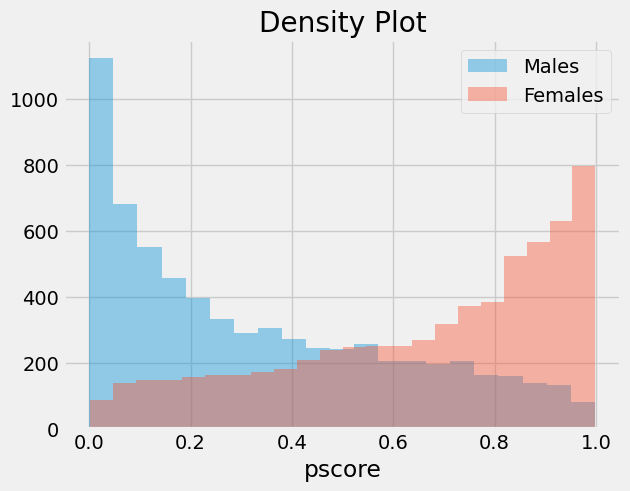

In [13]:
sns.distplot(pscores_df.query("female==0")["pscore"], kde=False, label="Males")
sns.distplot(pscores_df.query("female==1")["pscore"], kde=False, label="Females")
plt.title("Density Plot")
plt.legend();

### Estimate Gender Wage Gap using Propensity Scores

In [14]:
pscores_df['bins'] = pd.cut(pscores_df['pscore'], bins = 50, labels=range(1,51))
pscores_df['bins'] = pscores_df['bins'].astype('str')
pscores_df.head()

,log_hourslw,female,pscore,bins
0,3.738859,0.0,0.223398,12
1,1.341558,1.0,0.964493,49
2,2.672768,0.0,0.495368,25
3,3.397524,0.0,0.509276,26
4,2.251292,1.0,0.986898,50


**What are we comparing within each bin?**

In [15]:
pscores_df = pscores_df.groupby(['bins', 'female']).mean()
pscores_df.head()

log_hourslw    pscore
bins female                       
1    0.0        2.943461  0.009644
     1.0        2.633947  0.011005
10   0.0        3.088136  0.189337
     1.0        2.964010  0.190201
11   0.0        3.094400  0.209629

In [16]:
pscores_df['diffs'] = np.nan 

for idx in pscores_df.index.levels[0]:
    pscores_df.diffs[idx][1] = pscores_df.log_hourslw[idx][1] - pscores_df.log_hourslw[idx][0]
    
ate_df = pscores_df.dropna()
ate_df.head()

,,log_hourslw,pscore,diffs
bins,female,,,
1,1.0,2.633947,0.011005,-0.309514
10,1.0,2.964010,0.190201,-0.124126
11,1.0,3.024871,0.209701,-0.069529
12,1.0,3.055313,0.231010,-0.058725
13,1.0,3.095553,0.250309,0.004568


In [17]:
ATE = ate_df.diffs.mean()
print(ATE)

-0.1372269423804253


**How does this compare to the previous estimate?**

## Double Machine Learning

In this second exercise we will focus on the effect of having a child on hourly wages for women. The regression we will try to estimate is the following: 

$$log\_wageu_i=\delta_0 + \delta_1 child_i+ f(x_i) +\varepsilon_i$$ 


**Generally, in which cases would you use double ML? In your opinion is this a good setting?**

In [18]:
df_fem = df[df['female']==1]

olsc = smf.ols("log_wageu ~ child", df_fem).fit(cov_type='hc1')
ols2c = smf.ols('log_wageu ~ child + log_hourslw + age + I(age**2) + C(race) + C(cbsafips) + C(smsastat) + C(grade92) + C(unionmme) + C(unioncov) + C(ind02) + C(occ2012)', df_fem).fit(cov_type='hc1')

print(summary_col([olsc, ols2c], float_format='%0.3f',  info_dict={'N':lambda x: "{0:d}".format(int(x.nobs))}, regressor_order=['child']))


                                                                                                                         log_wageu I log_wageu II
-------------------------------------------------------------------------------------------------------------------------------------------------
child                                                                                                                    0.079       0.051       
                                                                                                                         (0.015)     (0.014)     
C(cbsafips)[T.10180]                                                                                                                 -0.160      
                                                                                                                                     (0.086)     
C(occ2012)[T.2850.0]                                                                                                       

**How would you interpret the coefficient on having a child?**

### Prepare Variables for ML

In [19]:
cont_vars = ['log_hourslw', 'age']
cat_vars = ['race', 'cbsafips', 'smsastat', 'grade92', 'unionmme','unioncov', 'ind02','occ2012']
df2 = df_fem.dropna(subset=['log_wageu', 'child'] + cont_vars + cat_vars)
for var in cat_vars:
    df2[var] = df2[var].astype('str')
    
print(df2.shape)
print(df2.child.value_counts())

(6413, 104)
child
0    4294
1    2119
Name: count, dtype: int64


In [20]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, PolynomialFeatures

encoder = OrdinalEncoder()
df2[cat_vars] = encoder.fit_transform(df2[cat_vars])
df2[cont_vars] = df2[cont_vars].astype('float32')

In [21]:
# standardize each continuous variable in X to variance one
scaler = StandardScaler().fit(df2[cont_vars])
df2[cont_vars] = scaler.transform(df2[cont_vars])
df2[cont_vars].head()

,log_hourslw,age
126278,-1.094507,1.380093
153511,-0.114744,0.271672
212363,-1.314141,1.518646
230119,1.330181,1.172264
59126,-0.249280,0.340948


In [22]:
D = df2['child']
y = df2['log_wageu']
X = df2[cat_vars + cont_vars]

### Double machine learning with the [econml](https://github.com/py-why/EconML) library

We will now rely on the econml library to easily estimate a model using double machine learning. You can find their documentation for this method [here](https://econml.azurewebsites.net/spec/estimation/dml.html) and a nice example notebook [here](https://github.com/py-why/EconML/blob/main/notebooks/Double%20Machine%20Learning%20Examples.ipynb).

In [23]:
from econml.dml import DML, LinearDML
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from econml.sklearn_extensions.linear_model import StatsModelsLinearRegression

In [24]:
# perform train/test split
X_train, X_test, D_train, D_test, y_train, y_test = train_test_split(X, D, y, test_size=0.2)

In [25]:
# LinearDML: https://econml.azurewebsites.net/_autosummary/econml.dml.LinearDML.html
est = LinearDML(model_y=RandomForestRegressor(n_estimators=100, max_depth =30, random_state=42),      # learn Y_hat using the controls
                model_t=RandomForestClassifier(n_estimators=100, max_depth =30, random_state=42),     # learn D_hat using the controls
                discrete_treatment=True,
                linear_first_stages=False,
                cv=6)

The econml library allows us to distinguish between two different types of confounders represented by a matrix *X* and a matrix *W*.

- *X* : confounders that interact with the treatment. we will be able to calculate heterogeneous treatment effects using them.
- *W*: confounders that don´t interact with the treatment. this can be a very high-dimensional matrix.

To be precise our model with these two types of confounders looks as follows:

$$ Y = D \cdot g(X) + W +  e $$

Where D is our treatment variable. In this first demonstration of double machine learning we will not focus on heterogeneous treatment effects and thus we will have all of our confounders as *W*.

In [26]:
est.fit(y_train, D_train, X=None, W=X_train) 

In [27]:
est.summary()

Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,-0.028,0.016,-1.683,0.092,-0.06,0.005


In [28]:
est.ate()

-0.027756046878674574

## Heterogenous Treatment Effects

In this part we will again assume that the treatment is having a child and we want to investigate the characteristics of women whose earnings are most affected by having a child. Using the syntax of econml this means that our confounders will be used as **X** (i.e. interacting with the treatment) and we will have no **W**.

In [29]:
# CausalForestDML: https://econml.azurewebsites.net/_autosummary/econml.dml.CausalForestDML.html
from econml.dml import CausalForestDML

In [30]:
est2 = CausalForestDML(model_y=RandomForestRegressor(),
                       model_t=RandomForestClassifier(),
                       discrete_treatment=True,
                       n_estimators=100,
                       max_depth=30,
                       verbose=0,
                       cv=6)

est2.tune(y_train, D_train, X=X_train, W=None)
est2.fit(y_train, D_train, X=X_train, W=None)

In [31]:
est2.summary()

Population summary results are available only if `cache_values=True` at fit time!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATE,-0.062,0.036,-1.729,0.084,-0.132,0.008
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-0.027,0.015,-1.833,0.067,-0.055,0.002
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
ATT,-0.134,0.104,-1.28,0.2,-0.339,0.071


In [32]:
# The average constant marginal treatment effect of each treatment for each outcome, 
# averaged over the training data and with a doubly robust correction
est2.ate__inference().summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
ATE,-0.062,0.036,-1.729,0.084,-0.132,0.008


In [33]:
# manually calculate the heterogeneous effect for each observation
te_pred2 = est2.effect(X_test)
lb2, ub2 = est2.effect_interval(X_test, alpha=0.01)

In [34]:
# get estimate heterogeneous effects with confidence intervals for all observations
df_he = est2.effect_inference(X_test).summary_frame(alpha=0.1, value=0, decimals=3)
#sort df by point estimate
df_he = df_he.sort_values(by='point_estimate', ascending=False)
df_he

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
997,0.079,0.105,0.749,0.454,-0.094,0.251
1085,0.054,0.063,0.855,0.392,-0.050,0.158
71,0.050,0.071,0.705,0.481,-0.067,0.167
1061,0.049,0.056,0.874,0.382,-0.043,0.142
216,0.048,0.076,0.634,0.526,-0.076,0.172
...,...,...,...,...,...,...
965,-0.093,0.072,-1.299,0.194,-0.211,0.025
136,-0.095,0.052,-1.819,0.069,-0.180,-0.009
84,-0.098,0.059,-1.654,0.098,-0.195,-0.001


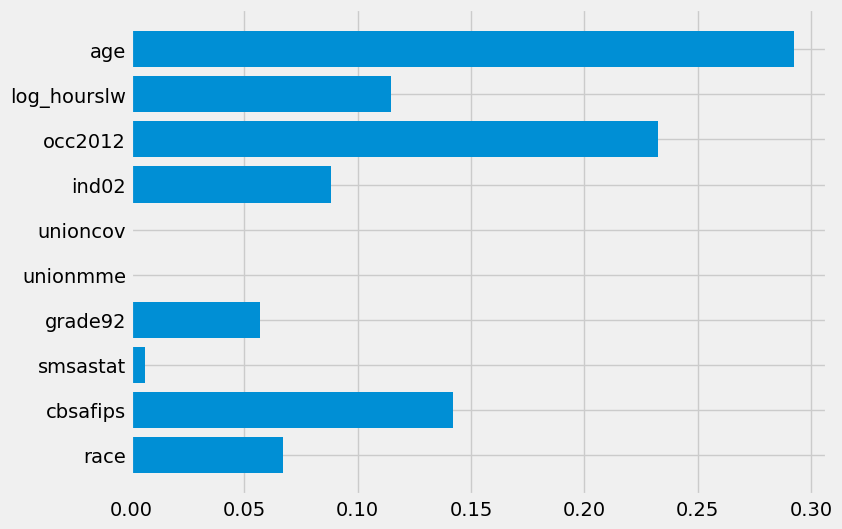

In [35]:
plt.figure(figsize=(8,6))
plt.barh(est2.cate_feature_names(), est2.feature_importances_)
plt.show()

**What would be an ideal setting to investigate heterogenous treatment effects?**

## Synthetic Control Method

In this part we will replicate the analysis of the paper from class on the anti-tobacco legislation ([Abadie et al., 2010]()). We will investigate the effect of this law implemented in California in 1988 on cigarettes sales. The (raw) reference regression is the following:

<center>$sales_s = \beta_0 + \beta_1 law_s + \varepsilon_s$</center>

where $sales_s$ is per capita cigarettes sales in sales $s$ and $law_s$ is a dummy equal to 1 if the law was passed in that state. 

In [36]:
df = pd.read_csv('https://raw.githubusercontent.com/OscarEngelbrektson/SyntheticControlMethods/3f496b36ed46c4e5c1e08ce6e903013e6eeb29df/examples/datasets/smoking_data.csv')
df['california'] = (df['state']=='California').astype('int')
df.head()

,state,year,cigsale,lnincome,beer,age15to24,retprice,california
0,Alabama,1970.0,89.8,NaN,NaN,0.178862,39.6,0
1,Alabama,1971.0,95.4,NaN,NaN,0.179928,42.7,0
2,Alabama,1972.0,101.1,9.498476,NaN,0.180994,42.3,0
3,Alabama,1973.0,102.9,9.550107,NaN,0.182060,42.1,0
4,Alabama,1974.0,108.2,9.537163,NaN,0.183126,43.1,0


In [37]:
ols = smf.ols('cigsale ~ california', data =df).fit(cov_type='hc1')
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                cigsale   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     21.41
Date:                Thu, 02 Nov 2023   Prob (F-statistic):           4.10e-06
Time:                        17:44:35   Log-Likelihood:                -5924.9
No. Observations:                1209   AIC:                         1.185e+04
Df Residuals:                    1207   BIC:                         1.186e+04
Df Model:                           1                                         
Covariance Type:                  hc1                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    119.5329      0.950    125.778      0.000     117.670     121.395
california   -24.9458      5.391     -4.628      0.000     -35.511     -14.380
==============================================================================
Omnibus:                      398.791   Durbin-Watson:                   0.113
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1666.836
Skew:                           1.522   Prob(JB):                         0.00
Kurtosis:                       7.881   Cond. No.                         6.33
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC1)
"""

**Can we interpret the coefficient on california as causal? Why?**

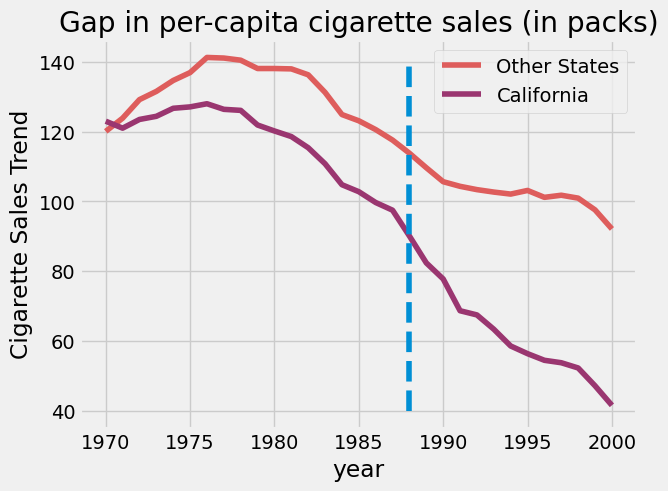

In [38]:
palette = sns.color_palette("flare", 2)
plot = sns.lineplot(data=df, x='year', y='cigsale', hue='california', palette=palette, ci=None)

plot.vlines(x=1988, ymin=40, ymax=140, linestyle="dashed")
plt.ylabel("Cigarette Sales Trend")
plt.title("Gap in per-capita cigarette sales (in packs)")
plot.legend_.set_title('')
new_labels = ['Other States', 'California']
for t, l in zip(plot.legend_.texts, new_labels):
    t.set_text(l)

**Could we use a difference in differences design in this context?**

You can find the refernece material for the python package on the synthetic control method at this [link](https://github.com/OscarEngelbrektson/SyntheticControlMethods)

In [39]:
from SyntheticControlMethods import Synth
del df['california']
sc = Synth(df, "cigsale", "state", "year", 1989, "California", n_optim=10, pen="auto")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         1 variables are exactly at the bounds

At iterate    0    f=  2.20995D+04    |proj g|=  2.00000D+01

At iterate    3    f=  1.36783D+02    |proj g|=  1.81324D+01

At iterate    6    f=  1.35389D+02    |proj g|=  1.92415D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6      9     11     0     0   1.924D-02   1.354D+02
  F =   135.38891275424294     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      6     95     17     0     6   6.490D+00   2.197D+03
  F =   2197.1482114395130     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44723D+03    |proj g|=  1.53292D+01



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



At iterate    3    f=  5.05584D+02    |proj g|=  6.73314D+00

At iterate    6    f=  3.29502D+02    |proj g|=  1.32355D+01

At iterate    9    f=  3.25170D+02    |proj g|=  5.47402D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     13     15     0     0   2.274D-04   3.252D+02
  F =   325.16995314035893     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.07230D+03    |proj g|=  0.00000D+00

       

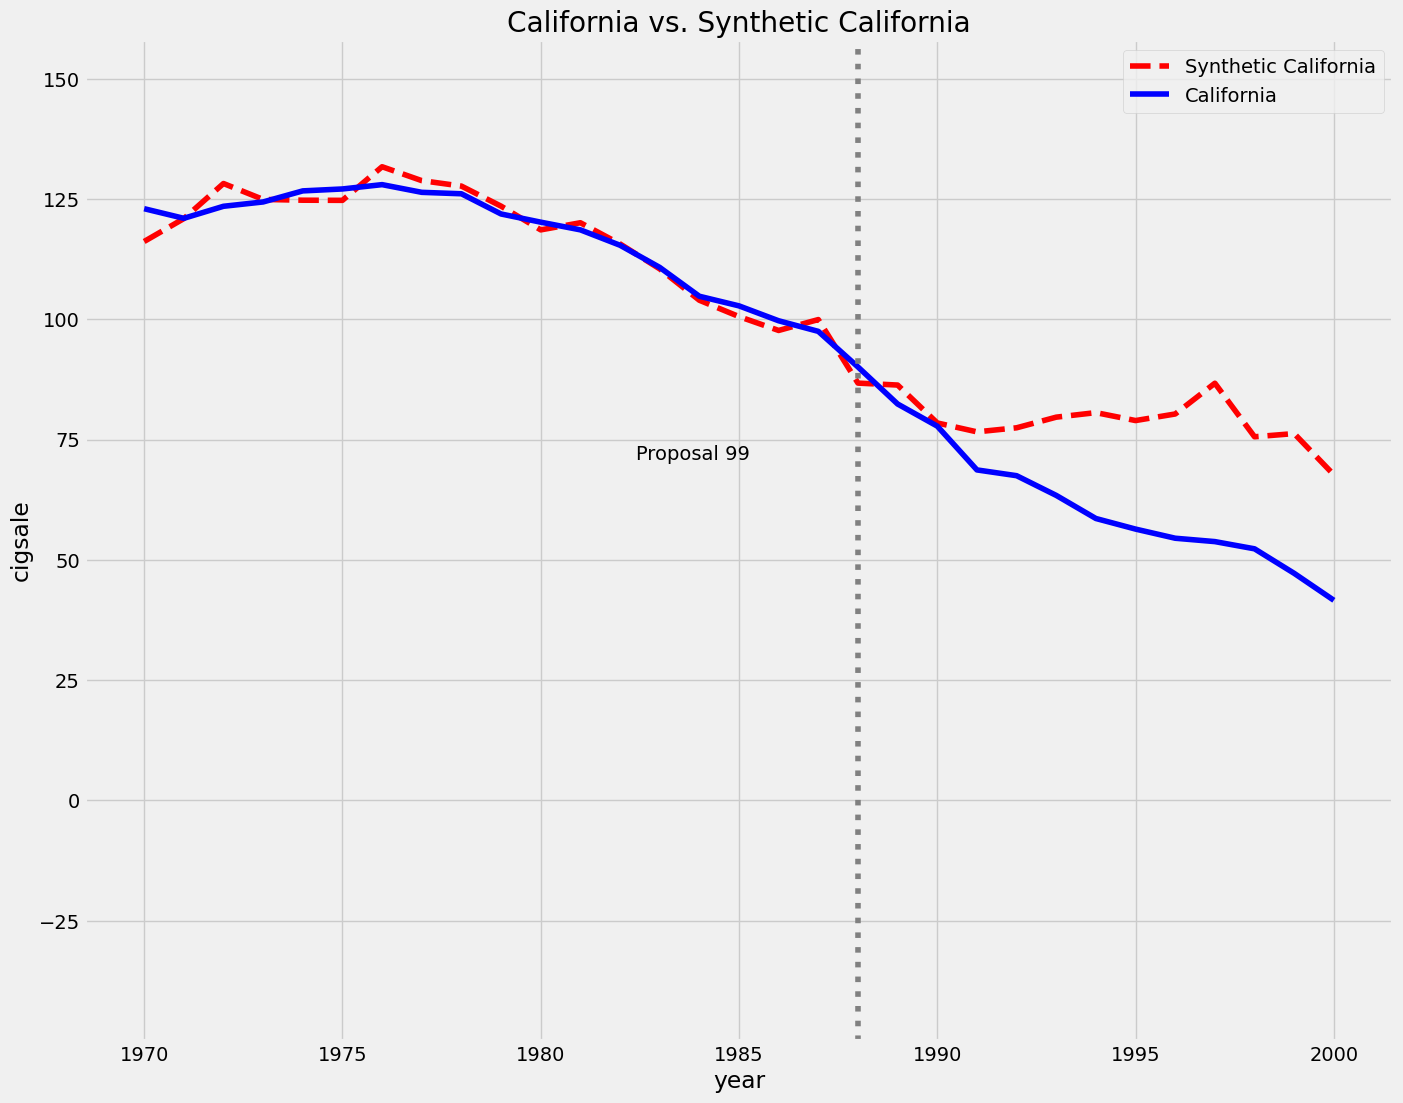

In [40]:
sc.plot(["original"], treated_label="California", 
            synth_label="Synthetic California", treatment_label="Proposal 99")

In [41]:
print(sc.original_data.weight_df)

                 Weight
New Hampshire  0.253153
Utah           0.746847
